**Final Project Submission**

Please fill out:
* Student name: Braydon Charles Janecek
* Student pace: Full-time
* Scheduled project review date/time: TBD
* Instructor name: Abhineet
* Blog post URL: TBD


In [1]:
import numpy as np
import glob
import os
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.ticker as mtick
%matplotlib inline
%pylab inline
import seaborn as sns

from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.metrics import Precision, Recall
from keras.applications import Xception, VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


C:\Users\bjane\Miniconda3\envs\learn-env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


# Diagnosing Pneumonia Using X-Ray Images and Deep Learning Overview

## Use Case and Problem Statement

This project was undertaken in May of 2020 during the Covid-19 pandemic in the United States. At this time the United States had seen well over a million confirmed cases and nearly one hundred thousands tests. Despited having tested over ten million people many parts of the United States, particularly rural areas, are facing difficulty testing suspected cases. At the time of writing (5/17/2020) our hospital in Wenatchee, WA has not been able to test anyone for the past week suspecting Covid-19 due to unavailability of tests. 

In order to properly re-open the economy swiftly and save ourselve from longterm financial turmoil it is necessary be able to diagnose Covid-19 patients with extremely quick turnaround times. Using existing x-ray technology and machine learning has the potential to facilitate rapid diagnoses when testing is unavailable. 

This is the problem which inspired this project. Due to limited x-ray images of Covid-19 patients available, the idea was to train a model on more general pneumonia cases (plentiful data) and apply that model to diagnosing Covid-19. 

# Data Pre-Processing

### Import Data, Resize, and Convert Images to Arrays

In order to feed image array data into our convolutional neural network model we must normalize all images to the same size. This is a little problematic as the x-rays have various aspect ratios. We do not want to change the aspect ratio of the images for fear of misrepresenting what is in the images! Unfortunatley, as our CNN will be required to "learn" that the black padding around the images is irrelevant via gradient descent (computationally expensive), we will elect to simply resize our images accepting that we will not be preserving our aspect ratio. 

We will be using the ImageDataGenerator method as this allows "lazy loading" meaning that the images are loaded just in time and only in batches. Regardless, in order to practice our data processing steps we are going to go ahead and undertake our data processing steps without the ImageDataGenerator methods as well. 

In [2]:
# directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'

In [204]:
# Get all the data in the directory chest_xrays/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(224, 224), 
        batch_size=624, 
        color_mode='grayscale')

# Get all the data in the directory chest_xrays/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        batch_size=5216,
        color_mode='grayscale')

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


Now let's take a look at the shape and preview an image. As we can see there is some slight distortion with the image being squished in the longitudal direction, however, our CNN should still be able to make out the important features. 

(224, 224, 1)


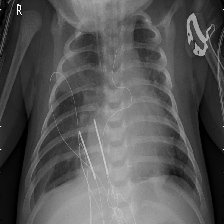

In [101]:
# print size and show image
print(train_images[10].shape)
array_to_img(train_images[10])

Now let us investigate our train_images and test_images arrays and shape. We need to change this from a 4D tensor to a 2D matrix which we will do using Numpy. 

In [102]:
# check shape
print("Train Data Shape: {}".format(train_images.shape))
print("Test Data Shape: {}".format(test_images.shape))

Train Data Shape: (5216, 224, 224, 1)
Test Data Shape: (624, 224, 224, 1)


In [104]:
# change shape of train and tets datasets
train_img_unrow = train_images.reshape(5216, -1).T
test_img_unrow = test_images.reshape(624, -1).T

In [105]:
# sanity check of new image array sizes
train_img_unrow.shape

(50176, 5216)

### Center, Standardize, and Normalize Pixel Data

Finally, we will normalize our pixel data by dividing by 255.0. It is important to normalize the data so that it facilitates convergence of the neural network.

In [188]:
# finally we will create normalized pixel distributions
train_img_normalized = train_img_unrow / 255.00
test_img_normalized = test_img_unrow / 255.00

### Analyze Target Data

Next we would like to check our label data. We can confirm its shape is correct and investigate the labels. As we can see below we do not know which column of our train_labels matrix represents normal and pneumonia classification, however, we may find this data under class indices of the generator objects. 

In [124]:
# check out raw labels
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [114]:
# check binary label classification
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Now we can select the 'PNEMONIA' column so that a pneumonia case is represented as a 1 and normal is represented as 0.

In [125]:
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]

Now let's take a look at our distribution of normal and pneumonia cases. 

In [142]:
# determine amount of normal vs. healthy cases in train and test sets
train_pnemonia_cases = sum(train_labels_final)
train_healthy_cases = len(train_labels_final[0]) - train_pnemonia_cases
test_pnemonia_cases = sum(test_labels_final)
test_healthy_cases = len(test_labels_final[0]) - test_pnemonia_cases

In [143]:
# print totals
print("Total Pneumonia Cases in Train Set: {}".format(train_pnemonia_cases))
print("Total Healthy Cases in Train Set: {}".format(train_healthy_cases))
print("Total Pneumonia Cases in Test Set: {}".format(test_pnemonia_cases))
print("Total Healthy Cases in Test Set: {}".format(test_healthy_cases))

Total Pneumonia Cases in Train Set: 3875.0
Total Healthy Cases in Train Set: 1341.0
Total Pneumonia Cases in Test Set: 390.0
Total Healthy Cases in Test Set: 234.0


Text(0, 0.5, 'Number of Cases')

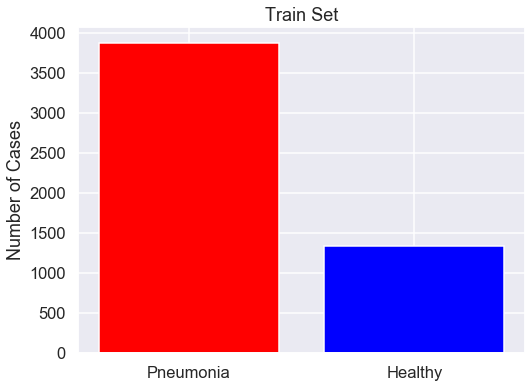

In [158]:
# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create barplot
plt.figure(figsize=(8,6))
plt.bar(x=['Pneumonia', 'Healthy'], height=[train_pnemonia_cases, train_healthy_cases], color=['red', 'blue'])
plt.title("Train Set")
plt.ylabel("Number of Cases")

Text(0, 0.5, 'Number of Cases')

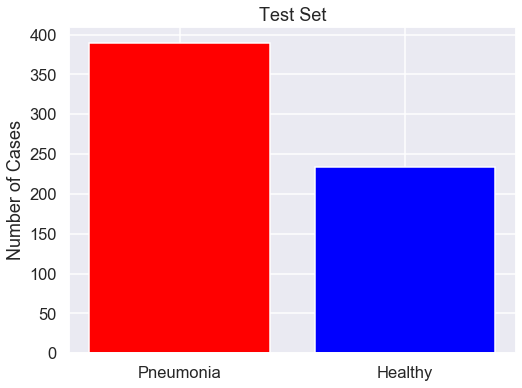

In [159]:
# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create barplot
plt.figure(figsize=(8,6))
plt.bar(x=['Pneumonia', 'Healthy'], height=[test_pnemonia_cases, test_healthy_cases], color=['red', 'blue'])
plt.title("Test Set")
plt.ylabel("Number of Cases")

# Baseline Convolutional Neural Network

As is typical for image classification problems will will use convolutional neural networks to classify our x-ray images. We will first create a baseline model which will be used for further improvement. Our baseline model will be based on the general architecture of the VGG16 model due to its relatively simple architecture and exceptional performance in the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) in 2014.

The general architecture will consist of stacking convolutional layers with 3x3 filters followed by max pooling layers. The pooling layers have the effect of making the output feature maps of the convolutional layers more robust to changes in the location of the feature in the image. A convolutional layer combined with a max pooling layer consists of one block. Blocks may be added with the convolutional layer in each block containing more filters and each block capable of detecting even higher order features of the images. 

Our first model will contain only one block. 

We will create a new ImageDataGenerator instance which will automatically load our image data in 64 image batches "as needed" and normalize them on the fly between zero and one.

Furthermore, the provided dataset only has 16 x-ray images for the validation set. This is puny relative to the training set so we are going to extract our own validation set from the training set. 

In [3]:
# initialize data generator instance which will standardize on the fly as we did previusly
# use 10% of training data as validation set
generator = ImageDataGenerator(rescale=1.0/255.0,
                               validation_split=0.10)

In [4]:
# Get all the data in the directory chest_xrays/test and resize
test_gen = generator.flow_from_directory(
        test_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64, 
        color_mode='grayscale',
        shuffle=False)

# Get all the data in the directory chest_xrays/train and resize
train_gen = generator.flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64,
        color_mode='grayscale',
        subset='training')

# create a validation dataset
val_gen = generator.flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64,
        color_mode='grayscale',
        subset='validation')

Found 624 images belonging to 2 classes.
Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [5]:
# glance at class indiced
test_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Next we shall define a function to build our single block VGG inspired baseline model. 

In [6]:
def create_model_VGG1(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # add one convolutional layer with 32 3x3 filters
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))

    # add max pooling layer
    model.add(MaxPooling2D())

    # add flattening layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [7]:
baseline_model = create_model_VGG1()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# define path to save model and set callbacks for future training
model_path = './VGG_batch_norm_best_model.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', 
                           patience=10,
                           mode='max',
                           verbose=1),
             ModelCheckpoint(model_path,
                             monitor='val_acc', 
                             save_best_only=True, 
                             mode='max',
                             verbose=0)]

In [9]:
# train model
history = baseline_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=30,
                              validation_data=val_gen, validation_steps=len(val_gen), callbacks=callbacks)


Epoch 1/30
74/74 [==============================] - 89s 1s/step - loss: 5.3594 - accuracy: 0.8741 - precision_1: 0.9109 - recall_1: 0.9206 - val_loss: 0.0026 - val_accuracy: 0.8810 - val_precision_1: 1.0000 - val_recall_1: 0.8398
Epoch 2/30


C:\Users\bjane\Miniconda3\envs\learn-env\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


74/74 [==============================] - 87s 1s/step - loss: 2.8663 - accuracy: 0.8856 - precision_1: 0.9239 - recall_1: 0.9220 - val_loss: 8.5994e-06 - val_accuracy: 0.9079 - val_precision_1: 0.9775 - val_recall_1: 0.8966
Epoch 3/30
74/74 [==============================] - 90s 1s/step - loss: 0.4148 - accuracy: 0.9725 - precision_1: 0.9828 - recall_1: 0.9802 - val_loss: 5.2620e-05 - val_accuracy: 0.9520 - val_precision_1: 0.9763 - val_recall_1: 0.9587
Epoch 4/30
74/74 [==============================] - 87s 1s/step - loss: 0.1809 - accuracy: 0.9810 - precision_1: 0.9879 - recall_1: 0.9865 - val_loss: 2.8964 - val_accuracy: 0.9482 - val_precision_1: 0.9545 - val_recall_1: 0.9767
Epoch 5/30
74/74 [==============================] - 86s 1s/step - loss: 0.1136 - accuracy: 0.9836 - precision_1: 0.9888 - recall_1: 0.9891 - val_loss: 2.9357e-04 - val_accuracy: 0.9578 - val_precision_1: 0.9790 - val_recall_1: 0.9638
Epoch 6/30
74/74 [==============================] - 86s 1s/step - loss: 0.0960 

In order to evaluate our model (and make this process easier in the future) we are going to write a function to evaluate accuracy, precision, and recall vs. epochs. This will help us determine if we are overfitting, underfitting, or have a good balance between the two. Furthermore, this will help us optimize our clssification threshold in order to maximize recall. 

In [10]:
# define model evaluation
def model_evaluation(history, p_r_iteration=2):

    # set context for plots
    sns.set_style('darkgrid') 
    sns.set_context('talk') 
    
    # define number of epochs
    epochs = range(1, len(history.history['accuracy'])+1)
    
    # plot accuracy
    plt.figure(figsize=(15,8))
    pyplot.title("Accuracy") 
    ax = plt.plot(epochs, history.history['accuracy'], color='blue', label='Train Data') 
    ax = plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot recall
    plt.figure(figsize=(15,8))
    pyplot.title("Precision") 
    plt.plot(epochs, history.history['recall_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_recall_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot precision
    plt.figure(figsize=(15,8))
    pyplot.title("Recall") 
    plt.plot(epochs, history.history['precision_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_precision_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()

As we can see on our accuracy plot our model very quickly overfits around five epochs into training. Recall seems to peak around five epochs in as well and actually begins to decline after ten epochs. 

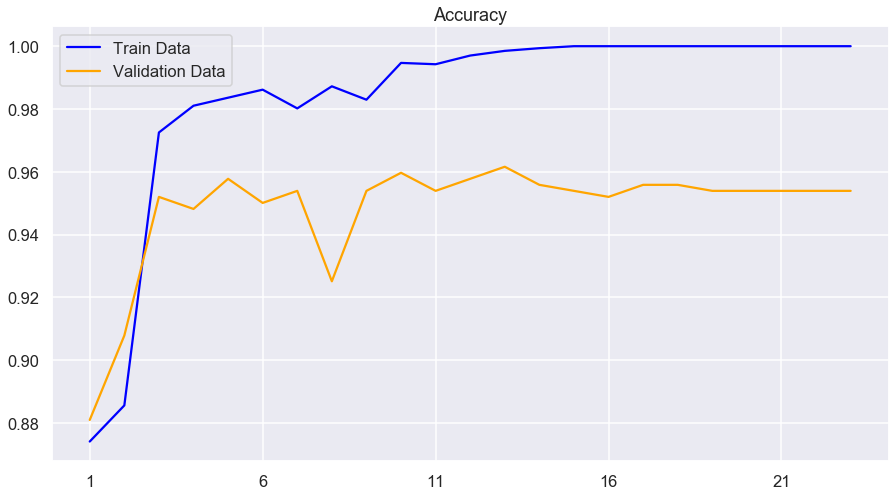

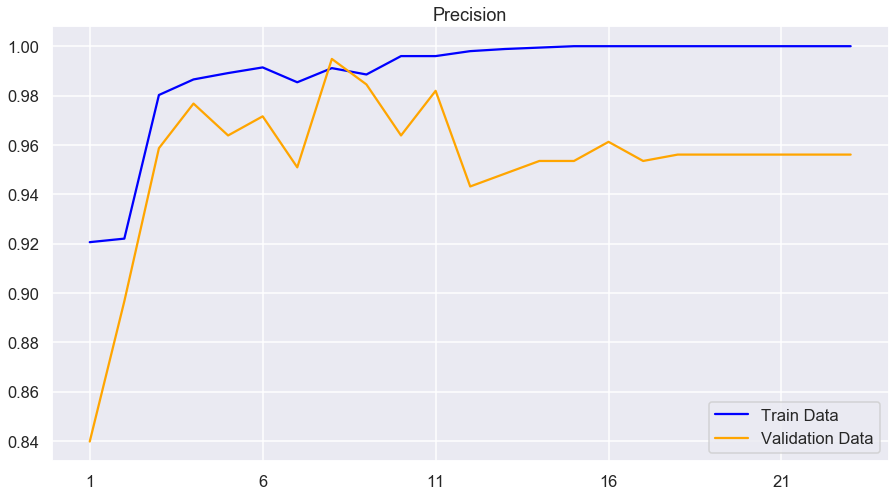

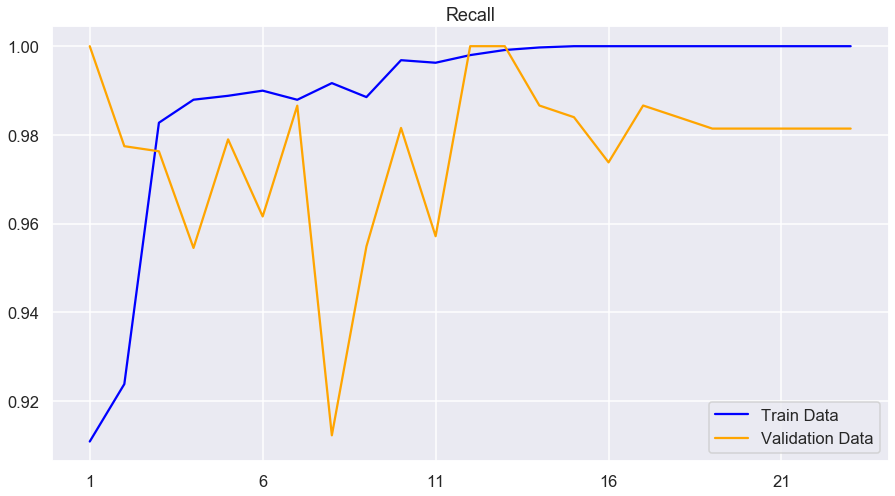

In [13]:
# evaluate baseline model
model_evaluation(history, p_r_iteration=1)

Finally, we shall evaluate the model on our test set. 

In [14]:
# evaluate on test set

baseline_model_test_accuracy = baseline_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
baseline_model_test_precision = baseline_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
baseline_model_test_recall = baseline_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(baseline_model_test_accuracy*100))
print("Test Set Precision: {}%".format(baseline_model_test_precision*100))
print("Test Set Recall: {}%".format(baseline_model_test_recall*100))

Test Set Accuracy: 74.83974099159241%
Test Set Precision: 71.37614488601685%
Test Set Recall: 99.74358677864075%


In [15]:
# plot confusion matrix for test set
Y_pred_vgg1 = baseline_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg1 = np.where(Y_pred_vgg1>0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg1)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg1))

Confusion Matrix
[[ 78 156]
 [  1 389]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.33      0.50       234
           1       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624



# Deeper Convolutional Neural Network

This model performed well, however, let's see how performance improves when we add two more convolution/pooling blocks to our architecture. The convolutional layer of each additional block will contain twice as many filters as the previous one. 

## Three Block VGG Architecture

In [312]:
def create_model_VGG_3(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(MaxPooling2D())

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [313]:
# create model
VGG_3_model = create_model_VGG_3()

Our previous model with a more simple architecture began to overfit our training data at around just five epochs. With an even more complex model we expect this overfitting to occur even more quickly. We will limit our training epochs to 10.

In [314]:
# train model
hitory_VGG_3 = VGG_3_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=10,
                              validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/10
74/74 [==============================] - 168s 2s/step - loss: 1.1234 - accuracy: 0.8692 - precision_3: 0.9027 - recall_3: 0.9235 - val_loss: 0.9792 - val_accuracy: 0.9098 - val_precision_3: 0.8991 - val_recall_3: 0.9897
Epoch 2/10
74/74 [==============================] - 173s 2s/step - loss: 0.0850 - accuracy: 0.9712 - precision_3: 0.9808 - recall_3: 0.9805 - val_loss: 0.5783 - val_accuracy: 0.9482 - val_precision_3: 0.9865 - val_recall_3: 0.9432
Epoch 3/10
74/74 [==============================] - 174s 2s/step - loss: 0.0532 - accuracy: 0.9823 - precision_3: 0.9885 - recall_3: 0.9877 - val_loss: 0.0360 - val_accuracy: 0.9482 - val_precision_3: 0.9545 - val_recall_3: 0.9767
Epoch 4/10
74/74 [==============================] - 176s 2s/step - loss: 0.0520 - accuracy: 0.9817 - precision_3: 0.9885 - recall_3: 0.9868 - val_loss: 0.6388 - val_accuracy: 0.9405 - val_precision_3: 0.9472 - val_recall_3: 0.9742
Epoch 5/10
74/74 [==============================] - 179s 2s/step - loss: 0.0

As we can see below, our model again began to grossly overfit of validation data around the 5th epoch. Furthermore, recall never really seemed to improve. 

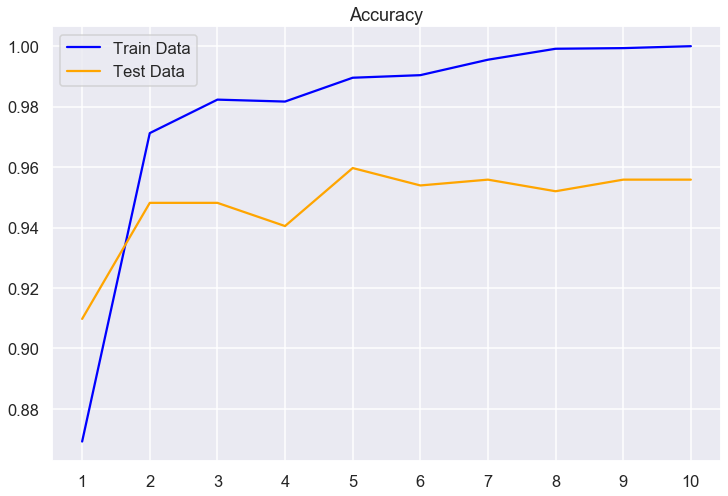

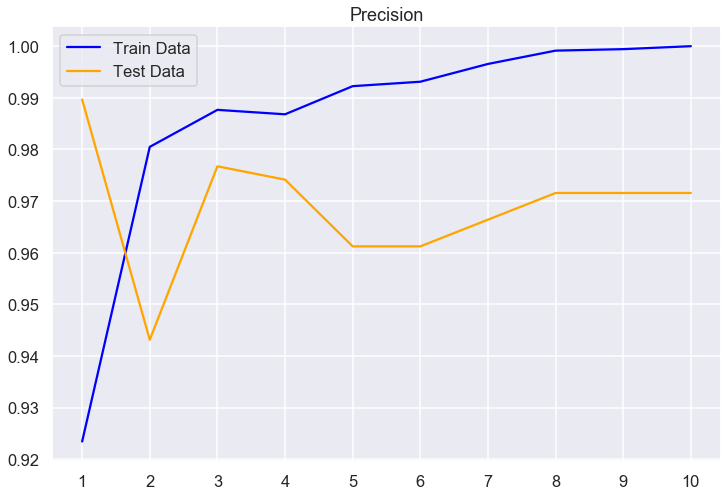

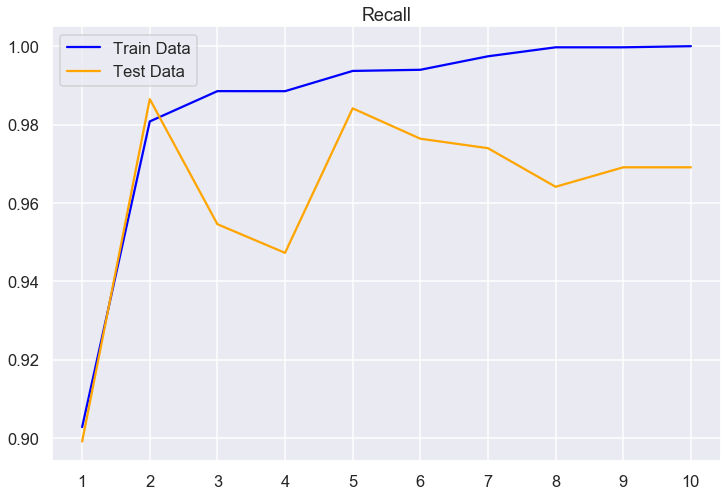

In [318]:
# evaluate model
model_evaluation(hitory_VGG_3, p_r_iteration=3)

Finally, we shall evaluate the model on our test set. 

In [342]:
# evaluate on test set

VGG_3_test_accuracy = VGG_3_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_3_test_precision = VGG_3_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_3_test_recall = VGG_3_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_3_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_3_test_precision*100))
print("Test Set Recall: {}%".format(VGG_3_test_recall*100))

Test Set Accuracy: 77.88461446762085%
Test Set Precision: 74.41860437393188%
Test Set Recall: 98.46153855323792%


In [611]:
# plot confusion matrix for test set
Y_pred_vgg3 = VGG_3_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg3 = np.where(Y_pred_vgg3>0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg3)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg3))

Confusion Matrix
[[102 132]
 [  6 384]]
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.44      0.60       234
           1       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



In [3]:
# calculate specificity
print("Specificity: {}".format((102/(102+132))))

Specificity: 0.4358974358974359


## Five Block VGG Architecture

We saw some good improvement in accuracy by going with three blocks so let's see if we can improve that once more by going with five blocks. 

In [614]:
def create_model_VGG_5(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(MaxPooling2D())

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block four
    model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # block five
    model.add(Conv2D(512, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [615]:
# create model
VGG_5_model = create_model_VGG_5()

In [616]:
# train model
hitory_VGG_5 = VGG_5_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=10,
                              validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/10
74/74 [==============================] - 789s 11s/step - loss: 0.4544 - accuracy: 0.8577 - precision_40: 0.9142 - recall_40: 0.8922 - val_loss: 0.1347 - val_accuracy: 0.8752 - val_precision_40: 0.9792 - val_recall_40: 0.8501
Epoch 2/10
74/74 [==============================] - 770s 10s/step - loss: 0.1039 - accuracy: 0.9619 - precision_40: 0.9780 - recall_40: 0.9705 - val_loss: 0.0078 - val_accuracy: 0.9559 - val_precision_40: 0.9715 - val_recall_40: 0.9690
Epoch 3/10
74/74 [==============================] - 764s 10s/step - loss: 0.0753 - accuracy: 0.9747 - precision_40: 0.9839 - recall_40: 0.9819 - val_loss: 0.3767 - val_accuracy: 0.9616 - val_precision_40: 0.9766 - val_recall_40: 0.9716
Epoch 4/10
74/74 [==============================] - 764s 10s/step - loss: 0.0409 - accuracy: 0.9825 - precision_40: 0.9885 - recall_40: 0.9880 - val_loss: 0.0322 - val_accuracy: 0.9559 - val_precision_40: 0.9715 - val_recall_40: 0.9690
Epoch 5/10
74/74 [==============================] - 766s

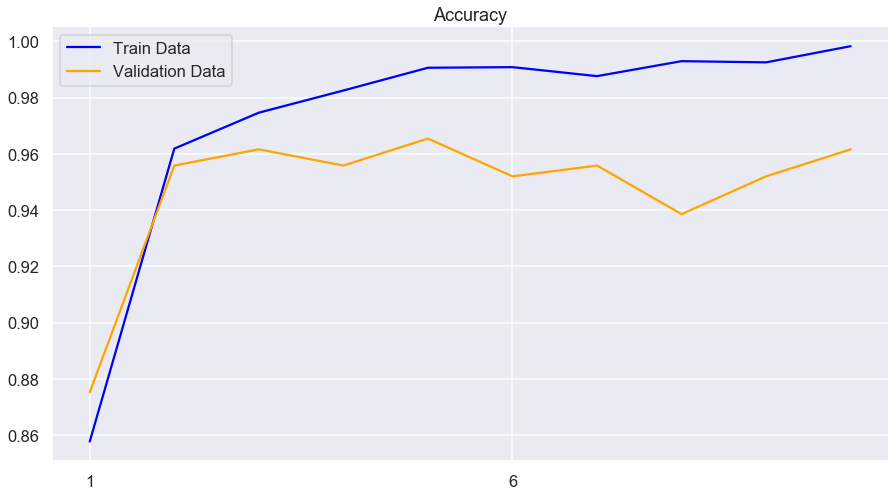

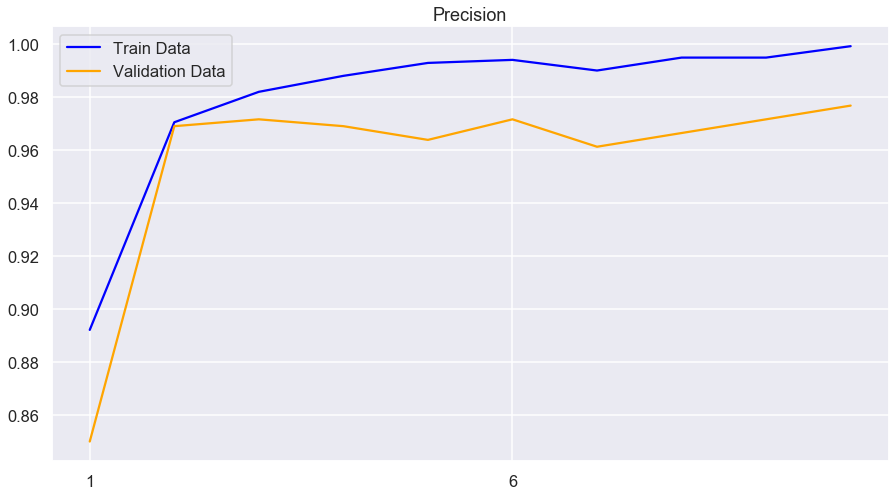

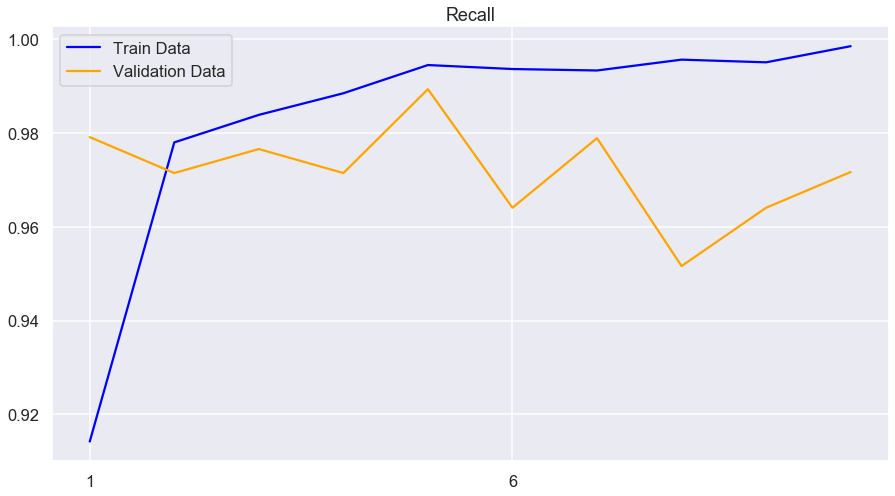

In [620]:
# evaluate model
model_evaluation(hitory_VGG_5, p_r_iteration=40)

In [621]:
# evaluate on test set

VGG_5_test_accuracy = VGG_5_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_5_test_precision = VGG_5_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_5_test_recall = VGG_5_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_5_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_5_test_precision*100))
print("Test Set Recall: {}%".format(VGG_5_test_recall*100))

Test Set Accuracy: 73.23718070983887%
Test Set Precision: 70.16274929046631%
Test Set Recall: 99.48717951774597%


In [622]:
# plot confusion matrix for test set
Y_pred_vgg5 = VGG_5_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg5 = np.where(Y_pred_vgg5 > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg5)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg5))

Confusion Matrix
[[ 69 165]
 [  2 388]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.29      0.45       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.64       624
weighted avg       0.80      0.73      0.68       624



# Regularize Deeper Convolutional Neural Network

## Adding Dropout Layers

Now that we've overfit our model let's try to add some dropout layers. As is common practice, we will dropout 20% of our neurons on the convolution layers and 40% of our neurons on the dense layer. 

In [464]:
def create_model_VGG_3_dropout(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # add final dropout layer
    model.add(Dropout(0.4))

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [465]:
# create model
VGG_3_dropout_model = create_model_VGG_3_dropout()

Because we are adding dropout layers we expect the validation accuracy to improve over more epochs. Therefore, we are going to increase the number of epochs to 30. 

In [466]:
# train model
history_VGG_3_dropout = VGG_3_dropout_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=30,
                              validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/30
74/74 [==============================] - 204s 3s/step - loss: 2.7458 - accuracy: 0.8068 - precision_25: 0.8582 - recall_25: 0.8865 - val_loss: 0.4043 - val_accuracy: 0.8292 - val_precision_25: 0.8465 - val_recall_25: 0.9406
Epoch 2/30
74/74 [==============================] - 208s 3s/step - loss: 0.1615 - accuracy: 0.9353 - precision_25: 0.9546 - recall_25: 0.9584 - val_loss: 0.3331 - val_accuracy: 0.9060 - val_precision_25: 0.9163 - val_recall_25: 0.9612
Epoch 3/30
74/74 [==============================] - 206s 3s/step - loss: 0.1071 - accuracy: 0.9589 - precision_25: 0.9722 - recall_25: 0.9725 - val_loss: 0.0261 - val_accuracy: 0.9309 - val_precision_25: 0.9355 - val_recall_25: 0.9742
Epoch 4/30
74/74 [==============================] - 207s 3s/step - loss: 0.0927 - accuracy: 0.9627 - precision_25: 0.9734 - recall_25: 0.9765 - val_loss: 0.1717 - val_accuracy: 0.9367 - val_precision_25: 0.9836 - val_recall_25: 0.9302
Epoch 5/30
74/74 [==============================] - 213s 3s/

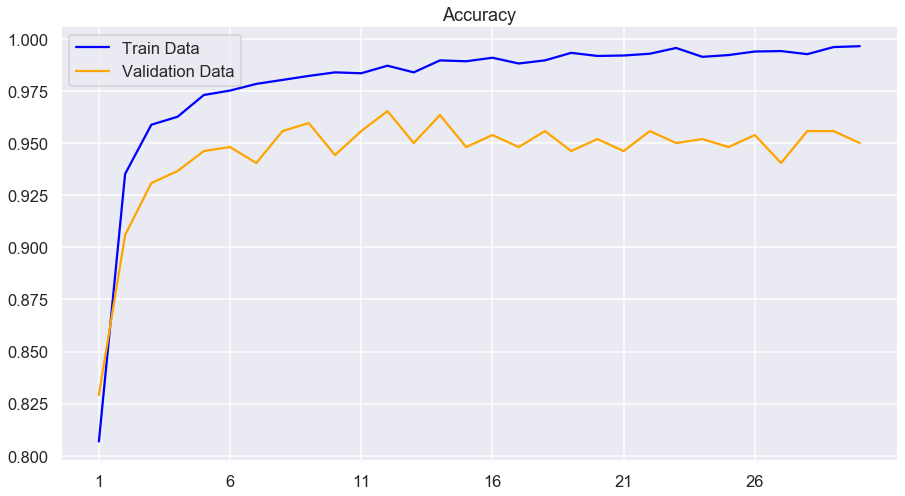

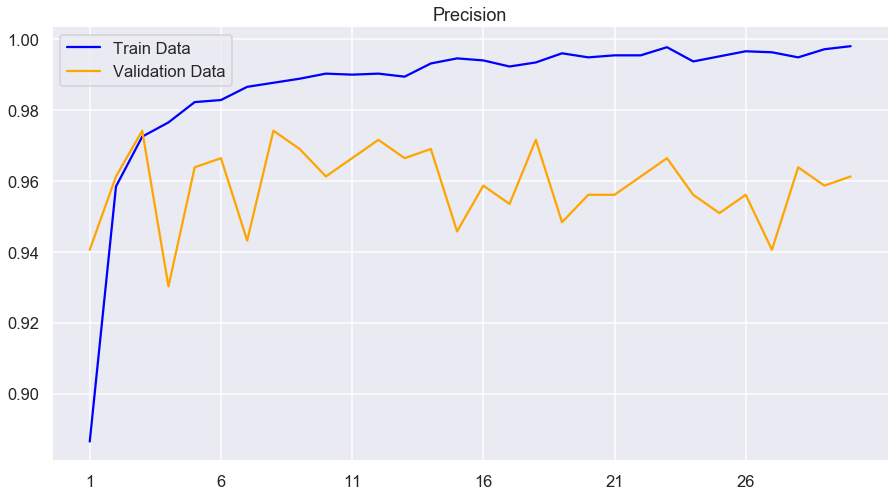

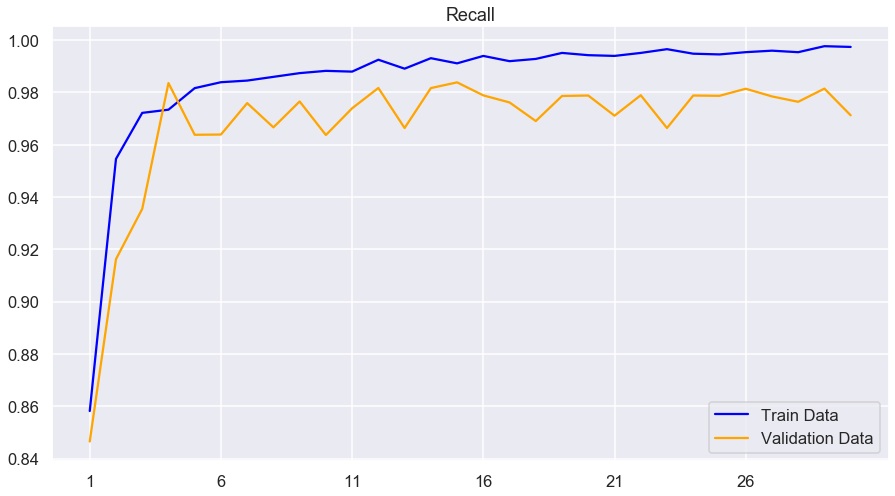

In [468]:
# evaluate model
model_evaluation(history_VGG_3_dropout, p_r_iteration=25)

Furthermore, we will now for the first time evaluate this model on the test set. It appears this method really decreased our accuracy, however, our recall improved slightly. There may be a better way to prevent overfitting, perhaps using image augmentation which we will attempt below. 

In [469]:
# evaluate on test set

VGG_3_dropout_test_accuracy = VGG_3_dropout_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_3_dropout_test_precision = VGG_3_dropout_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_3_dropout_test_recall = VGG_3_dropout_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_3_dropout_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_3_dropout_test_precision*100))
print("Test Set Recall: {}%".format(VGG_3_dropout_test_recall*100))

Test Set Accuracy: 74.67948794364929%
Test Set Precision: 71.32353186607361%
Test Set Recall: 99.48717951774597%


## Image Data Augmentation

We will now see if we can further improve our dropout model by adding in some augmentation to our training data. Image augmentation allows us to shift, rotate, flip, and adjust the brightness of our images in order to artificially create more images to train on. Image data augmentation can act as an alternative to overfitting as well. We will now evaluate this method and compare it to using dropout layers. For our image augmentation we will elect to use only horizontal flipping as this is the only one that really makes sense for chest x-rays.

We will not bother with vertical/horizontal shifts as our max pooling layers are already able to detect features in various sections of the image. Nor will we bother adjusting brightness as we are not dealing with photographs under different light conditions. 

In [630]:
# create new instance for augmented data
generator_augmented = ImageDataGenerator(rescale=1.0/255.0,
                                         validation_split=0.10,
                                         horizontal_flip=True)
                                         
# Get all the data in the directory chest_xrays/train and resize
train_gen_augmented = generator_augmented.flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64,
        color_mode='grayscale',
        subset='training')

# create a validation dataset
val_gen_augmented = generator_augmented.flow_from_directory(
        train_data_dir, 
        target_size=(224, 224), 
        class_mode='binary',
        batch_size=64,
        color_mode='grayscale',
        subset='validation')

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [453]:
# create augmented model
VGG_3_augmented_model = create_model_VGG_3(classification_threshold=0.50)

Note, previously we fit this model over 20 epochs and realized that the valdiation metrics were still improving. We are going to set the epochs to 50 now and let it ride. 

In [458]:
# train model
history_VGG_3_augmented = VGG_3_augmented_model.fit_generator(train_gen_augmented, steps_per_epoch=len(train_gen_augmented), 
                                                                    epochs=50, validation_data=val_gen_augmented, 
                                                                    validation_steps=len(val_gen_augmented))

Epoch 1/50
147/147 [==============================] - 188s 1s/step - loss: 0.0658 - accuracy: 0.9759 - precision_24: 0.9859 - recall_24: 0.9817 - val_loss: 4.7411e-04 - val_accuracy: 0.9443 - val_precision_24: 0.9864 - val_recall_24: 0.9380
Epoch 2/50
147/147 [==============================] - 186s 1s/step - loss: 0.0600 - accuracy: 0.9774 - precision_24: 0.9868 - recall_24: 0.9828 - val_loss: 7.6076e-04 - val_accuracy: 0.9443 - val_precision_24: 0.9613 - val_recall_24: 0.9638
Epoch 3/50
147/147 [==============================] - 189s 1s/step - loss: 0.0627 - accuracy: 0.9774 - precision_24: 0.9854 - recall_24: 0.9842 - val_loss: 0.8244 - val_accuracy: 0.9463 - val_precision_24: 0.9891 - val_recall_24: 0.9380
Epoch 4/50
147/147 [==============================] - 189s 1s/step - loss: 0.0601 - accuracy: 0.9764 - precision_24: 0.9842 - recall_24: 0.9839 - val_loss: 0.4220 - val_accuracy: 0.9578 - val_precision_24: 0.9620 - val_recall_24: 0.9819
Epoch 5/50
147/147 [========================

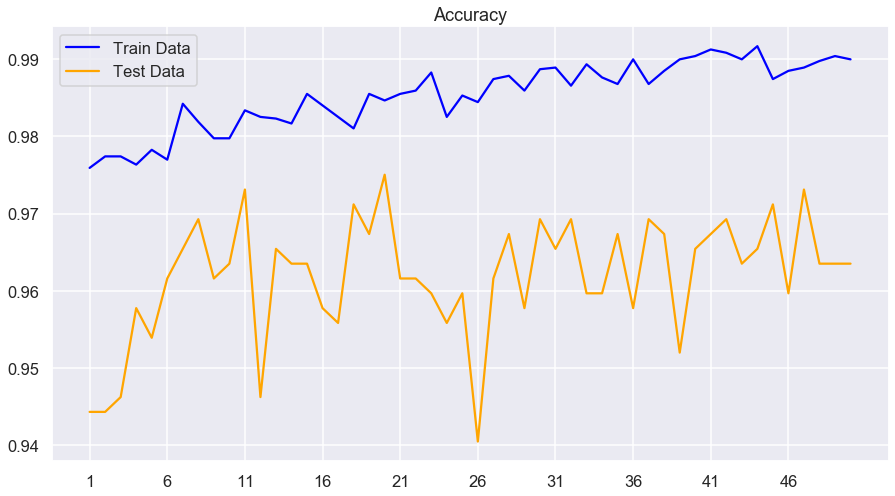

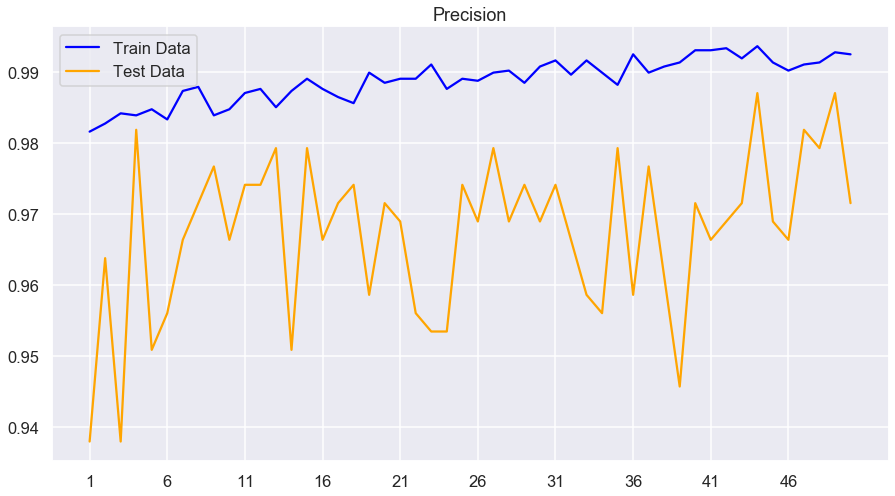

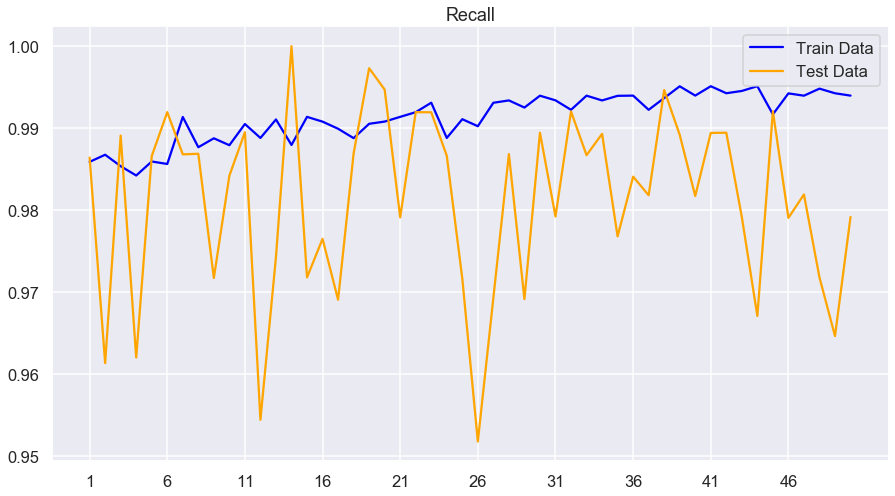

In [459]:
# evaluate model
model_evaluation(history_VGG_3_augmented, p_r_iteration=24)

In [463]:
# evaluate on test set

VGG_3_augmented_test_accuracy = VGG_3_augmented_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_3_augmented_test_precision = VGG_3_augmented_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_3_augmented_test_recall = VGG_3_augmented_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_3_augmented_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_3_augmented_test_precision*100))
print("Test Set Recall: {}%".format(VGG_3_augmented_test_recall*100))

Test Set Accuracy: 71.15384340286255%
Test Set Precision: 68.5512363910675%
Test Set Recall: 99.48717951774597%


## Adding Batch Normalization Layers

For one reason or another, it appears that adding dropout layers and image data augmentation resulted in lower accuracy in our test set. Before moving on, we'd like to try one more technique - batch normalization. Batch normalization layers will be added after the convolutional layers and the dense layer. The hope is that standardizing these outputs via batch normalization will result in faster training times and provide a mild reguarlarization effect. 

Furthmore, we will be using early stopping from here on out so that we may optimize the best number of epochs to train on. 

In [625]:
def create_model_VGG_BN(classification_threshold=0.5):
    # initialize model
    model = Sequential()

    # block one
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(224,224,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    # block two
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    # block three
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    # add flattening layer to feed into dense layer
    model.add(Flatten())

    # add dense layer
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # add batch norm layer
    model.add(BatchNormalization())

    # add output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [626]:
# create model
VGG_BN_model = create_model_VGG_BN()

In [631]:
# train model
history_VGG_BN = VGG_BN_model.fit_generator(train_gen_augmented, steps_per_epoch=len(train_gen_augmented), epochs=100,
                              validation_data=test_gen, validation_steps=len(test_gen), callbacks=callbacks)

Epoch 1/100
74/74 [==============================] - 1137s 15s/step - loss: 0.0952 - accuracy: 0.9698 - precision_41: 0.9813 - recall_41: 0.9779 - val_loss: 0.5391 - val_accuracy: 0.8429 - val_precision_41: 0.8668 - val_recall_41: 0.8846
Epoch 2/100
74/74 [==============================] - 1127s 15s/step - loss: 0.0465 - accuracy: 0.9857 - precision_41: 0.9903 - recall_41: 0.9905 - val_loss: 0.0216 - val_accuracy: 0.7372 - val_precision_41: 0.7055 - val_recall_41: 0.9949
Epoch 3/100
74/74 [==============================] - 1126s 15s/step - loss: 0.0320 - accuracy: 0.9894 - precision_41: 0.9931 - recall_41: 0.9925 - val_loss: 6.4021e-04 - val_accuracy: 0.7035 - val_precision_41: 0.6783 - val_recall_41: 1.0000
Epoch 4/100
74/74 [==============================] - 1123s 15s/step - loss: 0.0425 - accuracy: 0.9851 - precision_41: 0.9883 - recall_41: 0.9917 - val_loss: 1.0841e-04 - val_accuracy: 0.6410 - val_precision_41: 0.6352 - val_recall_41: 1.0000
Epoch 5/100
74/74 [=====================

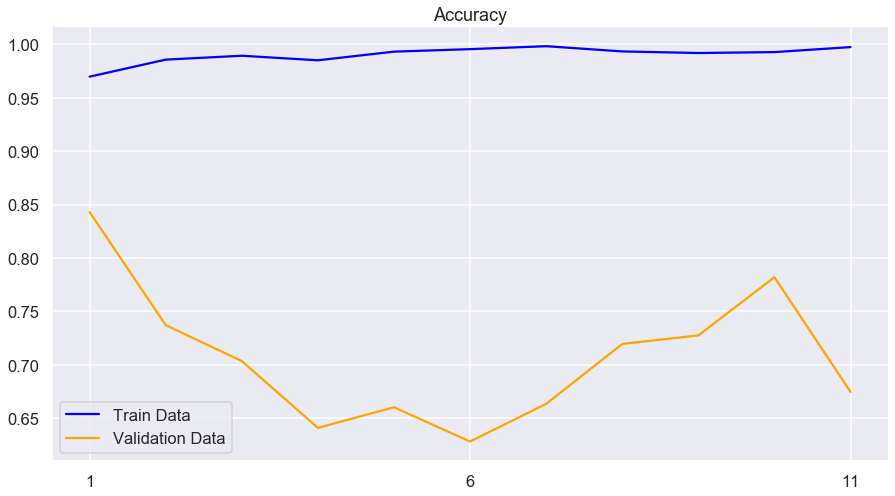

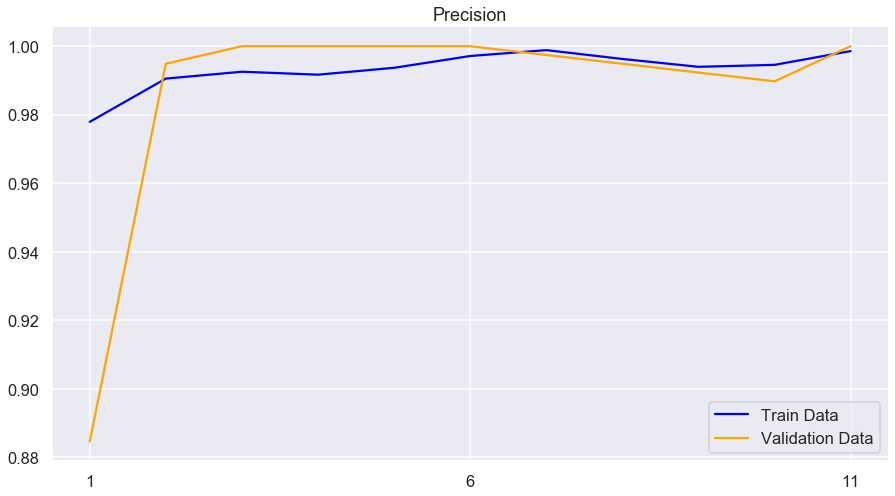

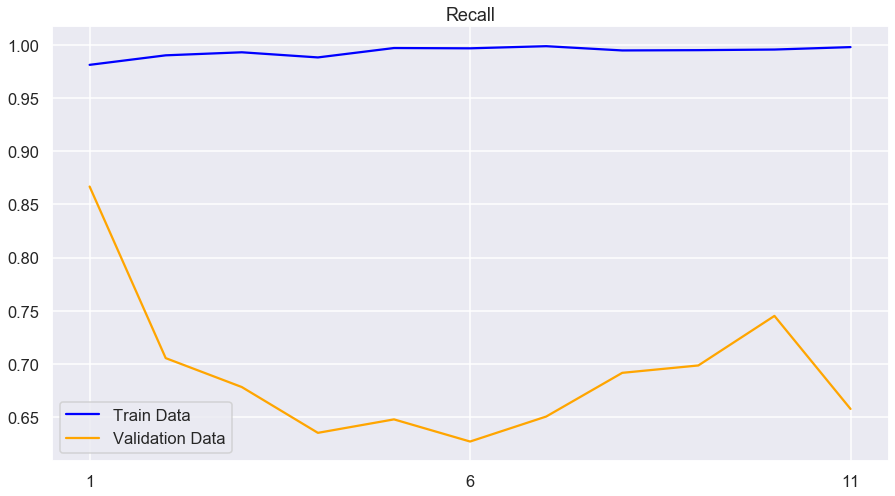

In [632]:
# evaluate model
model_evaluation(history_VGG_BN, p_r_iteration=41)

In [633]:
# evaluate on test set
VGG_BN_test_accuracy = VGG_BN_model.evaluate_generator(test_gen, steps=len(test_gen))[1]
VGG_BN_test_precision = VGG_BN_model.evaluate_generator(test_gen, steps=len(test_gen))[2]
VGG_BN_test_recall = VGG_BN_model.evaluate_generator(test_gen, steps=len(test_gen))[3]

print("Test Set Accuracy: {}%".format(VGG_BN_test_accuracy*100))
print("Test Set Precision: {}%".format(VGG_BN_test_precision*100))
print("Test Set Recall: {}%".format(VGG_BN_test_recall*100))

Test Set Accuracy: 67.46794581413269%
Test Set Precision: 65.76728224754333%
Test Set Recall: 100.0%


In [669]:
# plot confusion matrix for test set
Y_pred_vgg5 = VGG_5_model.predict_generator(test_gen, 10, workers=0)
y_pred_vgg5 = np.where(Y_pred_vgg5 > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen.classes, y_pred_vgg5)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen.classes, y_pred_vgg5))

Confusion Matrix
[[ 69 165]
 [  2 388]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.29      0.45       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.64       624
weighted avg       0.80      0.73      0.68       624



# Transfer learning Apporach

Now that we've created some of our own models let's see what type of performance we can obtain when using world-class, pretrained models from the start. Keras provides several options for pre-trained models which are available for transfer learning. We are going to select two of particular interest - VGG16 and Xception. 

Due to this notebook becoming cumbersome, we are going to train and evaluate these models in separate notebooks. Our four transfer learning models will be. 

1. VGG-16 with ImageNet weights
2. VGG-16 with trained weights
3. Xception with ImageNet weights
4. Xception with trained weights

# Final Model Evaluation

In [320]:
# compare accuracy, precision, recall across all models on test set; i.e. recall graph, accuracy graph, etc. 

# Recommendations and Further Studies

## Recommendations

Though our model has proven well at detecting typical pneumonia cases, even our best model continues to have an unnacceptable false positive rate on the test data. This could be due to having an inbalanced training dataset or for other reasons.

At this time, this model is not suitable for detecting pneumonia cases, however, with more data and training, it could improve substantially. 

## Further Studies

### Balance and Enlarge Dataset

Having a balanced and larger dataset more often than not will imrpove model accuracy, precision, recall, specificity, and sensitivity. Two options would be available for this. We could either:

1. Use image data augmentation to create more 'NORMAL' cases. This may not be the best option. 
2. Use another neural network architecture, Generative Adversarial Networks, to create synthetic x-ray images. 
3. Perhaps the best option of all would be to simply obtain more data. 

### More Transfer Learning

There are other high performing (ImageNet) models which I would be interested in testing including the NASNetLarge and Xception models. These models have different style architectures compared to VGG16 and could prove better for our problem. 

### Crop X-Ray Images

Reviewing the images in our dataset shows that there are a large number of x-rays which feature high aspect ratios. These x-rays contain edges along the side which are simply black and contribute nothing to diagnoses. Furthermore, they must be compressed to a common size for our algrorithm which will further distort the image. This distortion could be minimized by cropping these select images to only show the lungs so that these images may have a lower aspect ratio. Due to the large number of images in this dataset this would be a job suitable for Amazon's Mechanical Turk. 

# Appendix

## Evaluate on Detecting Covid-19

Out of curiosity we decided to test our best model, fully trained Xcception, on a dataset containing x-rays of 73 Covid-19 patients and 73 normal x-rays. The model performed poorly with slightly over 60% accuracy and 84% recall after training on a 50-50 training set. 